# Data Load

In [1]:
# !wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

https://huggingface.co/datasets/cointegrated/ru-paraphrase-NMT-Leipzig

paranmt_ru_leipzig.tsv

# Import

In [1]:
import pandas as pd
import nltk
from collections import Counter
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from IPython.display import clear_output

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Dataset

In [5]:
tokenizer = nltk.WordPunctTokenizer()

In [6]:
df = pd.read_csv('data.txt', sep='\t', names=['en', 'ru'])

In [92]:
df = pd.read_csv('paranmt_ru_leipzig.tsv', sep='\t')

In [94]:
len(df)

1000000

In [93]:
(df.en.apply(lambda item: len(item.split())) == df.ru.apply(lambda item: len(item.split()))).value_counts()

AttributeError: 'float' object has no attribute 'split'

In [8]:
class YandexDataset(Dataset):
    def __init__(self, src: list, trg: list):
        self.src = src
        self.trg = trg
        
    def __getitem__(self, index):
        return {
            'src': self.src[index],
            'trg': self.trg[index],
        }
    
    def __len__(self):
        return len(self.src)

In [9]:
def build_vocab(tokens: list, min_freq: int = 2):
    counter = Counter()
    
    for word in tokens:
        counter.update(word)
    
    counter = list(filter(lambda word: word[1] > min_freq, counter.items()))
    vocabulary = ['<pad>', '<unk>']
    vocabulary += [key for key, _ in counter]

    ind_to_vocab = dict(enumerate(vocabulary))
    vocab_to_ind = {value: key for key, value in ind_to_vocab.items()}

    return ind_to_vocab, vocab_to_ind

In [10]:
src = df.en.apply(
    lambda item: item.lower()
).apply(
    tokenizer.tokenize
).apply(
    lambda item: item[::-1]
).apply(
    lambda item: ['<sos>'] + item + ['<eos>']
).values.tolist()

In [11]:
src[0]

['<sos>',
 '.',
 'church',
 'trinity',
 'saint',
 'from',
 'away',
 'walk',
 'minute',
 '-',
 '3',
 'a',
 ',',
 'tbilisi',
 'in',
 'situated',
 'is',
 'hotel',
 'cordelia',
 '<eos>']

In [12]:
trg = df.ru.apply(
    lambda item: item.lower()
).apply(
    tokenizer.tokenize
).apply(
    lambda item: ['<sos>'] + item + ['<eos>']
).values.tolist()

In [13]:
dict(zip(src[11][::-1], trg[11]))

{'<eos>': '<sos>',
 'each': 'каждые',
 'apartment': 'апартаменты',
 'is': 'располагают',
 'fitted': 'балконом',
 'with': ',',
 'a': 'сейфом',
 'balcony': 'и',
 ',': 'телевизором',
 'flat': 'с',
 '-': 'плоским',
 'screen': 'экраном',
 'cable': 'и',
 'tv': 'кабельными',
 'and': 'каналами',
 'safety': '.',
 'deposit': '<eos>'}

In [14]:
src_ind_to_vocab, src_vocab_to_ind = build_vocab(src)
trg_ind_to_vocab, trg_vocab_to_ind = build_vocab(trg)

In [15]:
len(src_ind_to_vocab), len(trg_ind_to_vocab)

(7828, 10799)

In [16]:
train_data = YandexDataset(src[:40_000], trg[:40_000])
valid_data = YandexDataset(src[40_000:43_000], trg[40_000:43_000])
test_data = YandexDataset(src[43_000:], trg[43_000:])

In [17]:
src_transform = lambda x: src_vocab_to_ind[x] if x in src_vocab_to_ind else src_vocab_to_ind['<unk>']
trg_transform = lambda x: trg_vocab_to_ind[x] if x in trg_vocab_to_ind else trg_vocab_to_ind['<unk>']

In [18]:
def collate_fn(batch):
    max_src_len = max(len(row["src"]) for row in batch)
    max_trg_len = max(len(row["trg"]) for row in batch)
    max_len = max(max_src_len, max_trg_len)
    src_list = torch.empty((len(batch), max_len), dtype=torch.long)
    trg_list = torch.empty((len(batch), max_len), dtype=torch.long)

    for idx, row in enumerate(batch):
        to_pad_src = max_len - len(row["src"])
        to_pad_trg = max_len - len(row["trg"])
        _src = row['src']
        _trg = row['trg']
        src_list[idx] = torch.cat((torch.tensor(list(map(src_transform, _src))), 
                                torch.zeros(to_pad_src)))
        trg_list[idx] = torch.cat((torch.tensor(list(map(trg_transform, _trg))), 
                                torch.zeros(to_pad_trg)))
        
    return {
        'src': src_list,
        'trg': trg_list,
    }

In [19]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [20]:
for batch in train_loader:
    print(batch['src'].shape)
    print(batch['trg'].shape)
    break

torch.Size([32, 33])
torch.Size([32, 33])


In [21]:
batch['src']

tensor([[  2,   3,   4,  ...,   0,   0,   0],
        [  2,   3,  21,  ...,   0,   0,   0],
        [  2,   3,  35,  ...,   0,   0,   0],
        ...,
        [  2,   3,  78,  ...,   0,   0,   0],
        [  2,   3, 156,  ...,   0,   0,   0],
        [  2,   3,   8,  ...,   0,   0,   0]])

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Encoder

In [24]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 embed_dim: int,
                 hidden_dim: int,
                 dropout: float = 0.2,
                 n_layers: int = 2,
                 bidirectional: bool = True
                ):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_dim = embed_dim
        self.hid_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.rnn = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
#             batch_first=True,
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        # x = [batch_size, seq_len]
        embedded = self.embedding(x)
        
        # embedded = [batch_size, seq_len, emb_dim]
        out, (hidden, cell) = self.rnn(embedded)
        
        # out = [batch_size, seq_len, hidden_dim * 2]
        # hidden = [2 * n_layers, batch_size, hidden_dim]
        # cell = [2 * n_layers, batch_size, hidden_dim]
        if self.bidirectional:
#             hidden = hidden.transpose(0, 1).reshape(-1, self.n_layers, 2, self.hid_dim)
#             hidden = hidden.reshape(-1, self.n_layers, 2 * self.hid_dim)
            
#             cell = cell.transpose(0, 1).reshape(-1, self.n_layers, 2, self.hid_dim)
#             cell = cell.reshape(-1, self.n_layers, 2 * self.hid_dim)
            
            hidden = hidden.reshape(self.n_layers, 2, -1, self.hid_dim)
            hidden = hidden.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)

            cell = cell.reshape(self.n_layers, 2, -1, self.hid_dim)
            cell = cell.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)
        
        return out, hidden, cell

In [25]:
encoder = Encoder(
    vocab_size=len(src_ind_to_vocab),
    embed_dim=100,
    hidden_dim=128,
    n_layers=2,
    dropout=0.2,
    bidirectional=True
)

In [26]:
out, hidden, cell = encoder(batch['src'].transpose(0, 1))
print(out.shape, hidden.shape, cell.shape)

torch.Size([33, 32, 256]) torch.Size([2, 32, 256]) torch.Size([2, 32, 256])


In [28]:
hidden

tensor([[[ 0.1064, -0.4780,  0.1921,  ..., -0.0404, -0.3205, -0.0571],
         [ 0.1050, -0.4788,  0.1927,  ..., -0.0773, -0.3003, -0.0942],
         [ 0.1075, -0.4774,  0.1916,  ...,  0.0060, -0.3023, -0.0697],
         ...,
         [ 0.1073, -0.4776,  0.1919,  ..., -0.0095, -0.2331, -0.0370],
         [ 0.1077, -0.4772,  0.1916,  ..., -0.0706, -0.2600, -0.0531],
         [ 0.1077, -0.4772,  0.1916,  ..., -0.0246, -0.2701, -0.0796]],

        [[-0.2393, -0.0587, -0.0224,  ...,  0.0152,  0.0217,  0.0912],
         [-0.2408, -0.0580, -0.0220,  ...,  0.0388,  0.0875,  0.0459],
         [-0.2383, -0.0588, -0.0220,  ...,  0.0477,  0.0319,  0.0606],
         ...,
         [-0.2385, -0.0588, -0.0221,  ..., -0.0160,  0.0192,  0.0524],
         [-0.2380, -0.0588, -0.0219,  ...,  0.0173,  0.0849,  0.0630],
         [-0.2380, -0.0588, -0.0219,  ...,  0.0111,  0.0562,  0.0667]]],
       grad_fn=<UnsafeViewBackward0>)

In [29]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 embed_dim: int,
                 hidden_dim: int,
                 n_layers,
                ):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hidden_dim
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, embed_dim)
        
        self.rnn = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=False,
#             batch_first=True,
        )
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, hidden, cell):
        # x = [batch_size]
        # hidden = [n_layers * n_directions, batch_size, hidden_dim]
        # cell = [n_layers * n_directions, batch_size, hidden_dim]
        print(x.shape)
        
        x = x.unsqueeze(0)
        embedded = self.embedding(x)
        print(embedded.shape)
        # embedded = [1, batch_size, output_dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        print(output.shape, hidden.shape, cell.shape)
        
        predicted = self.fc(output.squeeze(0))
        print(predicted.shape)
        
        return predicted, hidden, cell

In [30]:
decoder = Decoder(
    output_dim=len(trg_ind_to_vocab),
    embed_dim=100,
    hidden_dim=128 * 2,
    n_layers=2,
)

In [31]:
hidden.shape

torch.Size([2, 32, 256])

In [32]:
decoder(batch['trg'].transpose(0, 1)[0], hidden, cell)

torch.Size([32])
torch.Size([1, 32, 100])
torch.Size([1, 32, 256]) torch.Size([2, 32, 256]) torch.Size([2, 32, 256])
torch.Size([32, 10799])


(tensor([[ 0.0511, -0.0724,  0.0173,  ..., -0.0569,  0.0695,  0.0259],
         [ 0.0560, -0.0650,  0.0107,  ..., -0.0495,  0.0742,  0.0274],
         [ 0.0517, -0.0754,  0.0170,  ..., -0.0491,  0.0741,  0.0239],
         ...,
         [ 0.0497, -0.0702,  0.0168,  ..., -0.0579,  0.0762,  0.0205],
         [ 0.0584, -0.0736,  0.0144,  ..., -0.0605,  0.0685,  0.0268],
         [ 0.0538, -0.0672,  0.0134,  ..., -0.0570,  0.0728,  0.0307]],
        grad_fn=<AddmmBackward0>),
 tensor([[[-0.0827, -0.2284,  0.0364,  ...,  0.0236, -0.1341,  0.0748],
          [-0.0897, -0.2266,  0.0351,  ...,  0.0106, -0.1188,  0.0380],
          [-0.0788, -0.2273,  0.0347,  ...,  0.0369, -0.1220,  0.0637],
          ...,
          [-0.0866, -0.2274,  0.0394,  ...,  0.0301, -0.0825,  0.0883],
          [-0.0932, -0.2208,  0.0381,  ...,  0.0136, -0.1014,  0.0802],
          [-0.0908, -0.2253,  0.0413,  ...,  0.0304, -0.1067,  0.0586]],
 
         [[-0.1325, -0.0230, -0.0375,  ..., -0.0014,  0.0352,  0.0751],
  

In [80]:
class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, bidirectional, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(input_size=emb_dim + enc_hid_dim * (1+bidirectional), 
                          hidden_size=dec_hid_dim, 
                          num_layers=n_layers, 
                          dropout=dropout
                          ) # use GRU
        
        self.out = nn.Linear(emb_dim + (1+bidirectional)*enc_hid_dim + dec_hid_dim, output_dim) # linear layer to get next word
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        #input = [batch size]
        # print(hidden.shape)
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0) # because only one word, no words sequence 
        
        #input = [1, batch size]
        embedded = self.embedding(input)
        
        #embedded = [1, batch size, emb dim]
        
        # get weighted sum of encoder_outputs
        a_t = self.attention(hidden, encoder_outputs)
#         print(out.shape)
        w_t = torch.sum(a_t * encoder_outputs, dim=0, keepdim=True) # w_t = [1, batch size, enc_hid_dim * n directions]
        # concatenate weighted sum and embedded, break through the GRU
        output, hidden = self.rnn(torch.concat([embedded, w_t], axis=2), hidden) # [1, batch size, dec_hid_dim]
        # get predictions
        # print(embedded.shape)
        # print(encoder_outputs.shape)
        # print(hidden.shape)
        prediction = self.out(torch.cat([embedded, # [1, batch size, emb dim]
                                         w_t, # [1, batch size, enc_hid_dim]
                                         hidden[-1,:,:].unsqueeze(0) # [1, batch size, dec_hid_dim]
                                         ], dim=2).squeeze(0))
        #prediction = [batch size, output dim]
        
        return prediction, hidden

In [81]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, bidirectional, temperature=1):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.temperature = temperature

        self.attn = nn.Linear((1+bidirectional) * enc_hid_dim + dec_hid_dim, enc_hid_dim)
        self.v = nn.Linear(enc_hid_dim, 1)
        
    def forward(self, hidden, encoder_outputs):
        
        # encoder_outputs = [src sent len, batch size, enc_hid_dim]
        # hidden = [1, batch size, dec_hid_dim]
        last_hidden = hidden[-1, :, :].unsqueeze(0)
        hiddens = last_hidden.repeat(encoder_outputs.shape[0], 1, 1)
        # repeat hidden and concatenate it with encoder_outputs
        concat_h_s = torch.concat([encoder_outputs, hiddens], dim=2)
        # calculate energy
        E = torch.tanh(self.attn(concat_h_s))
        # get attention, use softmax function which is defined, can change temperature
        a = self.v(E)
        print(a.shape)
        return softmax(a, temperature=self.temperature)

In [82]:
def softmax(x, temperature=10): # use your temperature
    e_x = torch.exp(x / temperature)
    return e_x / torch.sum(e_x, dim=0)

In [83]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim * (1+encoder.bidirectional) == decoder.dec_hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        # src = [src sent len, batch size]
        # trg = [trg sent len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        # encoder_outputs, hidden, cell = self.encoder(src)
        encoder_outputs, hidden, cell = self.encoder(src)

        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):

            output, hidden = self.decoder(input, hidden, encoder_outputs)

            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(-1) 
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [84]:
INPUT_DIM = len(src_vocab_to_ind)
OUTPUT_DIM = len(trg_vocab_to_ind)
ENC_EMB_DIM = 100
DEC_EMB_DIM = 100
DEC_HID_DIM = 256
BIDIRECTIONAL = True
ENC_HID_DIM = DEC_HID_DIM // (1 + BIDIRECTIONAL)
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(vocab_size=INPUT_DIM,
              embed_dim=ENC_EMB_DIM,
              hidden_dim=ENC_HID_DIM,
              n_layers=N_LAYERS,
              dropout=ENC_DROPOUT,
              bidirectional=BIDIRECTIONAL)

attention = Attention(enc_hid_dim=ENC_HID_DIM,
                      dec_hid_dim=DEC_HID_DIM,
                      bidirectional=BIDIRECTIONAL,
                      temperature=1)

dec = DecoderWithAttention(output_dim=OUTPUT_DIM,
                           emb_dim=DEC_EMB_DIM,
                           enc_hid_dim=ENC_HID_DIM,
                           dec_hid_dim=DEC_HID_DIM,
                           n_layers=N_LAYERS,
                           bidirectional=BIDIRECTIONAL,
                           dropout=DEC_DROPOUT,
                           attention=attention)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device)

In [85]:
model(batch['src'].transpose(0, 1), batch['trg'].transpose(0, 1)).shape

torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])
torch.Size([33, 32, 1])


torch.Size([33, 32, 10799])

In [45]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,045,368 trainable parameters


In [46]:
print(f'The model has {count_parameters(enc):,} trainable parameters')

The model has 1,413,584 trainable parameters


In [47]:
print(f'The model has {count_parameters(attention):,} trainable parameters')

The model has 65,793 trainable parameters


In [48]:
print(f'The model has {count_parameters(dec):,} trainable parameters')

The model has 8,631,784 trainable parameters


In [86]:
out, hid, cell = enc(batch['src'].transpose(0, 1))

In [87]:
hid

tensor([[[ 1.7987e-01, -2.5862e-01,  1.2340e-01,  ..., -1.6928e-03,
           5.2860e-03, -7.1080e-02],
         [ 1.8005e-01, -2.5866e-01,  1.2256e-01,  ..., -3.5929e-02,
           5.5964e-02, -1.2284e-01],
         [ 1.8005e-01, -2.5851e-01,  1.2342e-01,  ..., -4.2736e-02,
          -9.1661e-02, -1.2436e-01],
         ...,
         [ 1.7998e-01, -2.5858e-01,  1.2349e-01,  ..., -2.2708e-02,
           2.0011e-02, -9.4228e-02],
         [ 1.8009e-01, -2.5837e-01,  1.2357e-01,  ...,  6.1523e-02,
          -5.6790e-02, -1.4611e-01],
         [ 1.8009e-01, -2.5839e-01,  1.2355e-01,  ...,  2.1434e-02,
          -3.8592e-03, -1.0123e-01]],

        [[-8.5914e-02,  1.8230e-02, -4.8975e-02,  ...,  7.2725e-02,
          -6.2789e-03,  3.3094e-02],
         [-8.3012e-02,  2.0139e-02, -4.5738e-02,  ...,  9.6784e-02,
           8.7174e-03, -1.1650e-04],
         [-8.6309e-02,  1.7667e-02, -4.9517e-02,  ...,  7.3170e-02,
           5.6856e-02, -1.2827e-02],
         ...,
         [-8.6137e-02,  1

In [91]:
attention(hidden, out)

torch.Size([33, 32, 1])


tensor([[[0.0304],
         [0.0304],
         [0.0304],
         ...,
         [0.0306],
         [0.0306],
         [0.0304]],

        [[0.0304],
         [0.0303],
         [0.0304],
         ...,
         [0.0306],
         [0.0306],
         [0.0305]],

        [[0.0305],
         [0.0301],
         [0.0305],
         ...,
         [0.0305],
         [0.0306],
         [0.0307]],

        ...,

        [[0.0303],
         [0.0302],
         [0.0304],
         ...,
         [0.0303],
         [0.0303],
         [0.0302]],

        [[0.0303],
         [0.0302],
         [0.0304],
         ...,
         [0.0303],
         [0.0303],
         [0.0302]],

        [[0.0303],
         [0.0302],
         [0.0304],
         ...,
         [0.0303],
         [0.0303],
         [0.0302]]], grad_fn=<DivBackward0>)

In [52]:
attention(hidden, out).shape

torch.Size([33, 32, 1])

In [53]:
PAD_IDX = trg_vocab_to_ind['<pad>']
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    i = 0
    for batch in tqdm(iterator):
        
        src = batch['src'].transpose(0, 1)
        trg = batch['trg'].transpose(0, 1)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].reshape(-1, OUTPUT_DIM)
        trg = trg[1:].reshape(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        i+=1

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].reshape(-1, OUTPUT_DIM)
            trg = trg[1:].reshape(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

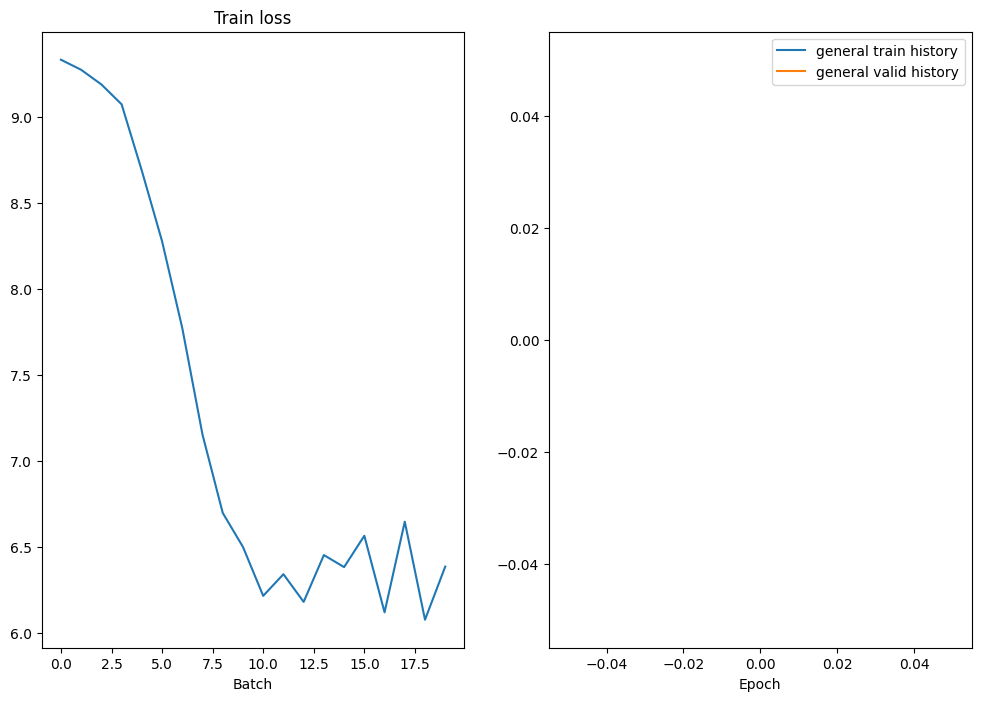

  2%|▊                                                   | 20/1250 [00:45<46:42,  2.28s/it]

KeyboardInterrupt



In [54]:
train_history = []
valid_history = []
train(model, train_loader, optimizer, criterion, 2, train_history, valid_history)

In [44]:
def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == '<eos>':
            break
        yield token

def remove_tech_tokens(tokens_iter, tokens_to_remove=['<sos>', '<unk>', '<pad>']):
    return [x for x in tokens_iter if x not in tokens_to_remove]

def generate_translation(src, trg, model, TRG_vocab, SRC_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output[1:].argmax(-1)

#     source = remove_tech_tokens(cut_on_eos([SRC_vocab[x] for x in list(src[:,0].cpu().numpy())]))
    original = remove_tech_tokens(cut_on_eos([TRG_vocab[x] for x in list(trg[:,0].cpu().numpy())]))
    generated = remove_tech_tokens(cut_on_eos([TRG_vocab[x] for x in list(output[:, 0].cpu().numpy())]))
    
#     print('Source: {}'.format(' '.join(source[::-1])))
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

def get_text(x, TRG_vocab):
    generated = remove_tech_tokens(cut_on_eos([TRG_vocab[elem] for elem in list(x)]))
    return generated

In [45]:
batch = next(iter(test_loader))

for idx in range(10):
    src = batch['src']
    trg = batch['trg']
    trg = trg.transpose(0, 1)
    #trg = [trg sent len, batch size]
    src = src.transpose(0, 1)
    #src = [src sent len, batch size]
    src = src[:, idx:idx+1].to(device)
    trg = trg[:, idx:idx+1].to(device)
    generate_translation(src, trg, model, trg_ind_to_vocab, src_ind_to_vocab)

Original: в хостеле можно поиграть в настольный теннис и бильярд , а в окрестностях — заняться популярным в этих местах катанием на лыжах и велосипедными прогулками .
Generated: в отеле и в и , а также .

Original: к услугам гостей спа - салон , в котором работают сауна , паровая баня и инфракрасная сауна .
Generated: в числе удобств апартаментов , в и , и , а также .

Original: различные бары и рестораны находятся в 5 минутах ходьбы от дома отдыха .
Generated: расстояние до аэропорта .

Original: на полностью оборудованной кухне в распоряжении гостей холодильник и посуда .
Generated: в числе удобств телевизор с плоским экраном и .

Original: на территории обустроена бесплатная частная парковка .
Generated: в территории обустроена бесплатная парковка .

Original: площадь каталонии находится всего в 5 минутах ходьбы от этого гостевого дома . в местах общего пользования предоставляется бесплатный wi - fi .
Generated: в .

Original: отель находится в 18 км от города шклярска - и в 21 км о